In [1]:
# Basket name: Patents+OCHEM+Enamine+Bradley+Begström (training)
# This basket belongs to user: published, created by dan2097


from rdkit.Chem import AllChem, MolFromSmiles, Descriptors
import pandas as pd
from tqdm import tqdm
from tqdm.contrib import tzip
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from multiprocessing import Pool

random.seed(42)

/home/ec2-user/np-clinical-trials/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# https://coconut.naturalproducts.net/download
coconut_smiles_list = (
    pd.read_csv(
        "https://coconut.naturalproducts.net/download/absolutesmiles",
        names=["smiles"],
    )["smiles"]
    .unique()
    .tolist()
)
# coconut_smiles_list = random.sample(coconut_smiles_list, 1000)

In [3]:
OCHEM_subset_smiles_list = (
    pd.read_csv(
        "/home/ec2-user/np-clinical-trials/support/patents_ochem_enamine_bradley_begstr_m_training_.csv",
        sep=";",
    )["SMILES"]
    .unique()
    .tolist()
)
# OCHEM_subset_smiles_list = random.sample(OCHEM_subset_smiles_list, 1000)

/tmp/ipykernel_32849/1088225864.py:2: DtypeWarning: Columns (6,13,14,15,16,17,23) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(


In [4]:
synthetic_smiles_list = (
    pd.read_csv(
        "/home/ec2-user/np-clinical-trials/support/synthetic_compounds.tsv", sep="\t"
    )["smiles"]
    .unique()
    .tolist()
)
# synthetic_smiles_list = random.sample(synthetic_smiles_list, 1000)

In [5]:
results_dictionary = {
    "OCHEM": {"SMILES": OCHEM_subset_smiles_list},
    "Coconut": {"SMILES": coconut_smiles_list},
    "Synthetic": {"SMILES": synthetic_smiles_list},
}


def conversion_with_rdkit(input_smiles):
    try:
        return MolFromSmiles(input_smiles)
    except:
        return None


fpgen = AllChem.GetRDKitFPGenerator()
for current_subset in results_dictionary:
    molecules_list = []
    with Pool(16) as p:
        molecules_list = list(
            tqdm(
                p.imap(
                    conversion_with_rdkit, results_dictionary[current_subset]["SMILES"]
                ),
                total=len(results_dictionary[current_subset]["SMILES"]),
            )
        )

    results_dictionary[current_subset]["Molecules"] = molecules_list

  2%|▏         | 5061/275132 [00:00<00:42, 6393.37it/s][17:59:10] Explicit valence for atom # 16 S, 9, is greater than permitted
[17:59:10] Explicit valence for atom # 10 S, 9, is greater than permitted
  6%|▌         | 16628/275132 [00:02<00:37, 6833.94it/s][17:59:11] Explicit valence for atom # 14 S, 9, is greater than permitted
[17:59:11] Explicit valence for atom # 11 S, 9, is greater than permitted
 10%|█         | 28072/275132 [00:04<00:37, 6643.38it/s][17:59:13] Explicit valence for atom # 22 S, 9, is greater than permitted
[17:59:13] Explicit valence for atom # 30 S, 9, is greater than permitted
[17:59:13] Explicit valence for atom # 29 S, 9, is greater than permitted
[17:59:13] Explicit valence for atom # 24 S, 9, is greater than permitted
 12%|█▏        | 32633/275132 [00:05<00:38, 6234.23it/s][17:59:14] Explicit valence for atom # 12 S, 9, is greater than permitted
[17:59:14] Explicit valence for atom # 11 S, 9, is greater than permitted
[17:59:14] Explicit valence for atom 

In [6]:
fpgen = AllChem.GetRDKitFPGenerator()

In [7]:
def calculate_fingerprints(input_molecule):
    try:
        return Descriptors.CalcMolDescriptors(input_molecule)
    except:
        return None


for current_subset in results_dictionary:
    fps_list, valid_smiles = [], []
    with Pool(16) as p:
        fps_list = list(
            tqdm(
                p.imap(
                    calculate_fingerprints,
                    results_dictionary[current_subset]["Molecules"],
                ),
                total=len(results_dictionary[current_subset]["Molecules"]),
            )
        )
    valid_smiles = []
    for current_smiles, current_fingerprint in tzip(
        results_dictionary[current_subset]["SMILES"], fps_list
    ):
        if current_fingerprint is not None:
            valid_smiles.append(current_smiles)
        else:
            valid_smiles.append(None)

    fps_df = pd.DataFrame(fps_list)
    fps_df["SMILES"] = valid_smiles
    fps_df["source"] = current_subset
    results_dictionary[current_subset]["features"] = fps_df

  5%|▌         | 45217/895557 [04:47<1:29:58, 157.52it/s]


KeyboardInterrupt: 

In [ ]:
full_fingerprints_df = pd.concat(
    [
        results_dictionary["OCHEM"]["features"],
        results_dictionary["Coconut"]["features"],
        results_dictionary["Synthetic"]["features"],
    ]
)

In [ ]:
ids_column = full_fingerprints_df[["source", "SMILES"]]
features_df = full_fingerprints_df.drop(columns=["SMILES", "source"])

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df.fillna(0))

In [ ]:
PCA_object = PCA(n_components=2)

In [ ]:
PCA_features = PCA_object.fit_transform(scaled_features)

/home/ec2-user/np-clinical-trials/.venv/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ec2-user/np-clinical-trials/.venv/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ec2-user/np-clinical-trials/.venv/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ec2-user/np-clinical-trials/.venv/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

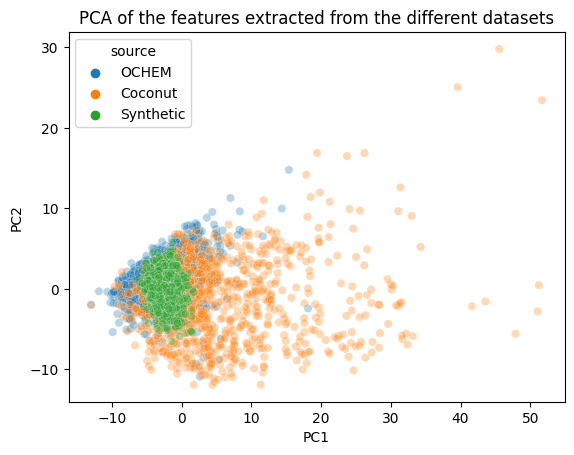

In [ ]:
sns.scatterplot(
    x=PCA_features[:, 0],
    y=PCA_features[:, 1],
    hue=ids_column["source"],
    alpha=0.3,
)
plt.title("PCA of the features extracted from the different datasets")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.savefig("PCA_plot.png")